# Experiment Anaysis for Study_Level inference

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [6]:
def load_path(model):
    model_path = []
    for i in range(5):
        if model == 'effnb7':
            path = f'./study_efnb7_my_model/history{i}.csv'
        elif model == 'efnv2':
            path = f"./study_efnv2_model/history{i}.csv"
        elif model == 'efnv2_xl':
            path = f'./study_efnv2_xl_model/history{i}.csv'
        model_path.append(path)
    return model_path, model

def draw_plot(path, model_name):
    val_losses = []
    val_auces = []
    epochs = []
    for p in path:            
        temp = pd.read_csv(p)
        temp = temp[temp['val_loss']==temp['val_loss'].min()]
        val_losses.append(temp.iloc[0,3])
        val_auces.append(temp.iloc[0,4])
        epochs.append(temp.iloc[0,0])
    
    plt.figure(figsize=(8,5))
    plt.bar(np.arange(0,5)-0.2, val_auces, 
            color='dodgerblue', edgecolor='black', 
            linewidth=0.4, width=0.4, 
            alpha = 0.5, label='val_auc')
    plt.bar(np.arange(0,5)+0.2, val_losses, 
            color='springgreen', edgecolor='black', 
            linewidth=0.4, width=0.4, 
            alpha = 0.5, label='val_loss')
    plt.xticks(np.arange(0,5), epochs)
    plt.xlabel('epochs at best')
    
    for i in range(0,5):
        plt.text(x = i-0.3, y = val_auces[i]+0.01, s = f"{val_auces[i]:.3f}")
        plt.text(x = i+0.1, y = val_losses[i]+0.01, s = f"{val_losses[i]:.3f}")
        
    plt.axhline(y=np.mean(val_auces), 
                color='orange', linestyle='--')
    plt.text(x = 0, y = 0.6, s = f"mean val_auc : {np.mean(val_auces):.3f}",
             weight='bold', size=12)
    
    plt.axhline(y=np.mean(val_losses),
                color='r', linestyle='--')
    plt.text(x = 0, y = 0.5, s = f"mean val_loss : {np.mean(val_losses):.3f}",
             weight='bold', size=12)
    
    plt.title(f"{model_name} Kfold (validation)", weight='bold', size=16, loc='left')
    plt.ylim([0.4, 1.2])
    plt.legend(loc='best')
    plt.show();
    
def load_history_file(path):
    model_name = path[0].split('/')[1]
    history = []
    for p in path:
        tmp = pd.read_csv(p)
        if len(tmp.columns) > 6:
            tmp = tmp.iloc[:, [0, 1, 3, 4, 6, 7]] # epochs, loss, auc, val_loss, val_auc, lr
        history.append(tmp)
    return history, model_name 

def draw_history(history, model_name):
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16,16))

    for i in range(6):
        for j in range(5):
            tmp = history[j].iloc[:,i]
            axes[i//cols][i%cols].plot(tmp, label=f"Fold {j}", 
                                       alpha=0.4, marker='o',
                                       linewidth=0.8, markersize=4)
        axes[i//cols][i%cols].grid()
        axes[i//cols][i%cols].set_title(f"{history[j].columns[i]}", weight='bold', loc='left', size=14)
        axes[i//cols][i%cols].legend(loc='best')
        
    plt.suptitle(f"{model_name} Model history", weight='bold', size = 20)
    plt.show();

def check_val_loss_lr(history):    
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(12,12))

    for i in range(5):
        tmp = history[i].iloc[:,[0,3,5]]
        length = tmp.shape[0]
        axes[i//cols][i%cols].plot(tmp.iloc[:,1], 
                                   label=f"{tmp.columns[1]}", 
                                   alpha=0.6, marker='o',
                                   linewidth=0.8, markersize=4)
        
        axes[i//cols][i%cols].fill_between(np.arange(length), 
                                           tmp.iloc[:,1],  
                                           alpha=0.1)
        
        axes[i//cols][i%cols].plot(tmp.iloc[:,2]*1000, 
                                   label=f"{tmp.columns[2]} * 1000", 
                                   alpha=0.6, marker='^',
                                   linewidth=0.8, markersize=4)
        
        
        tmp = tmp[tmp['val_loss']==tmp.iloc[:,1].min()]
        
        axes[i//cols][i%cols].axvline(x = tmp.iloc[0,0], linestyle='--', color='red', alpha= 0.5)
        axes[i//cols][i%cols].grid()
        axes[i//cols][i%cols].set_title(f"Fold {i}", weight='bold', loc='left', size=14)
        axes[i//cols][i%cols].legend(loc='best')
        
    plt.suptitle(f"check val_loss & lr", weight='bold', size=20)
    plt.tight_layout()
    plt.show();
    
def analyze(model):
    path, model_name = load_path(model)
    draw_plot(path, model_name)
    history, model_name = load_history_file(path)
    draw_history(history, model_name)
    check_val_loss_lr(history)
    return history

In [4]:
model_lst = ['effnb7', 'efnv2', 'efnv2_xl']
model_history = {}

## 1. EfficientNetB7

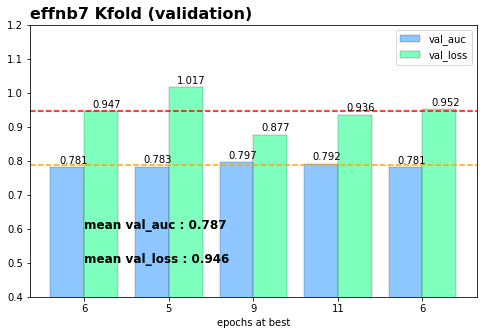

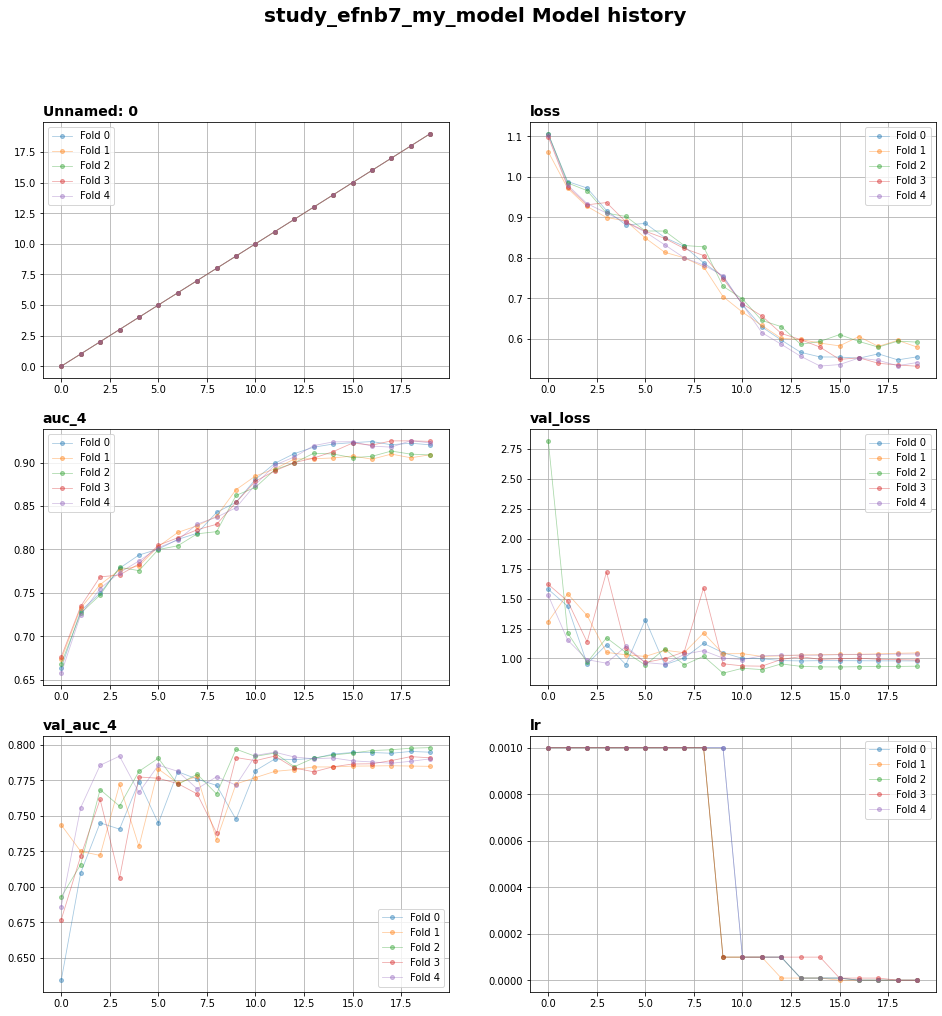

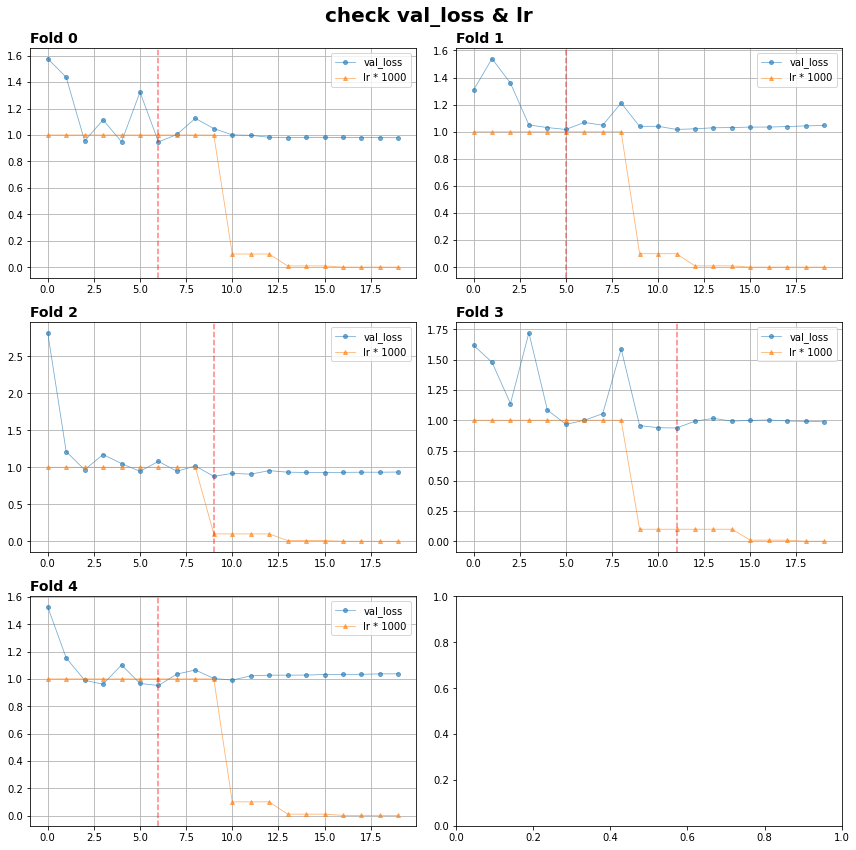

In [50]:
efnb7 = analyze(model_lst[0])
model_history[model_lst[0]] = efnb7

### val_loss & learning rate by Plateau

val_loss 와 lr 을 비교해서 보니, plateau 에 의해 lr 이 떨어졌을 때가 val_loss 의 최저점이며, best.pt 가 생성되는 시점.  
그 이후로는 더 학습을 해도 큰 의미가 없다.  
Plateau 는 val_loss 에 연동되고, learning_rate 감소 이전에 val_loss 가 들쭉날쭉 한다는 것은, model 이 학습하면서 robust 를 갖추지 못했다는 것.  
초반 학습이 생각만큼 잘 안된다는 의미이므로, 초반에 learning_rate scheduler 를 통한 조정으로 학습을 더 잘 시켜보도록 해보자.   

----
## 2. EfficientNetV2

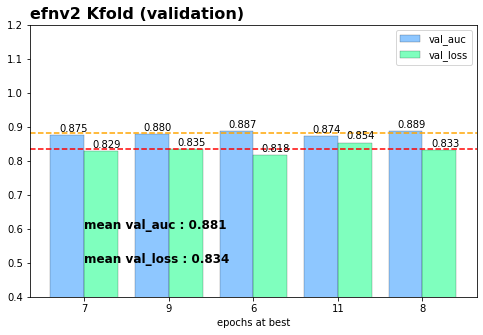

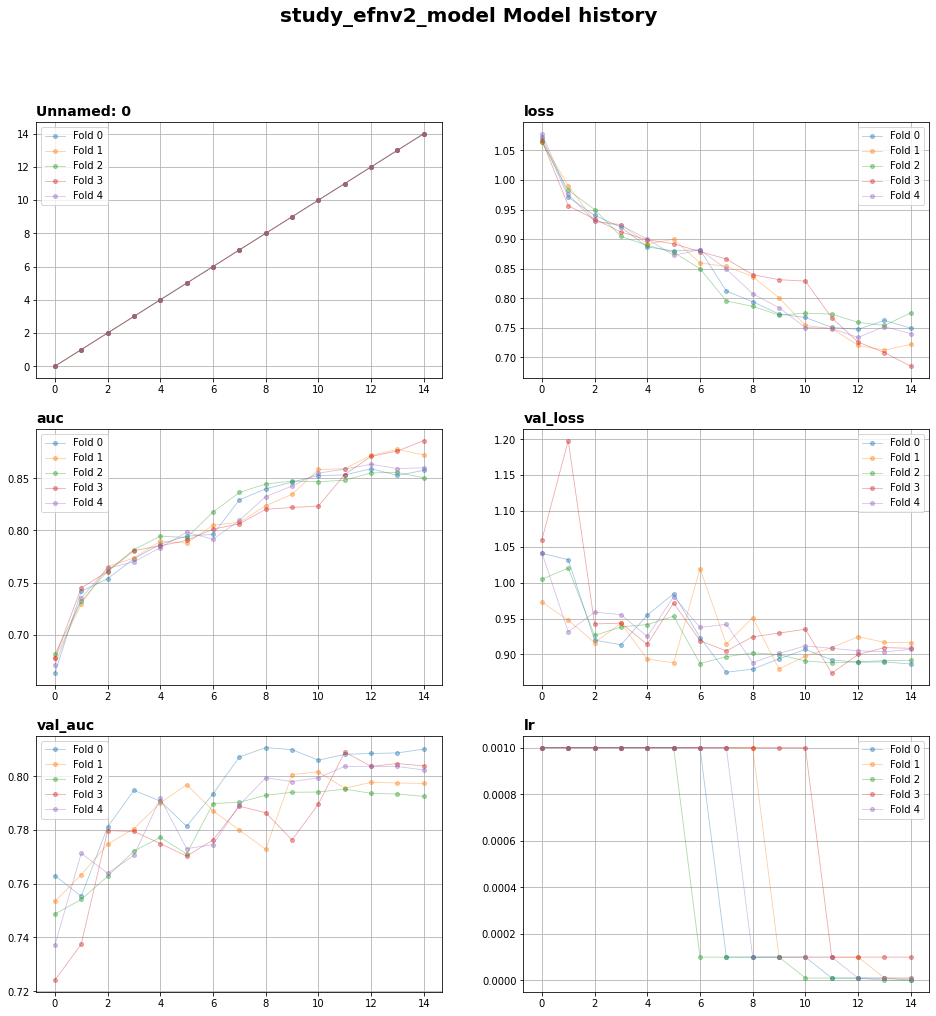

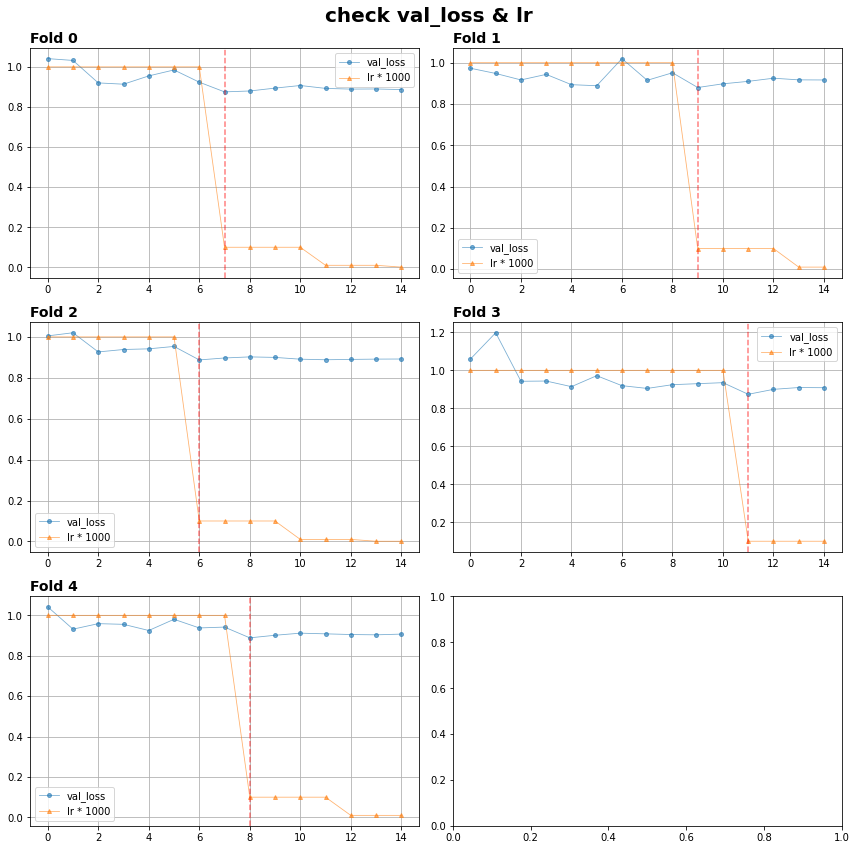

In [51]:
efnv2b1 = analyze(model_lst[1])
model_history[model_lst[1]] = efnv2b1

* **EfficientNetV2_large**    
    확실히 EfficientNetB7 에 비해 더 좋은 성능을 보인다.  
    history 를 체크해보자.  

처음에는 당연히 train set 에 대해서는 학습이 되겠지만, val set 에 대해서는 eval 이 좋지 않으므로, 모델의 robust 가 좋지 않다고 볼 수 있다.  그래서 Plateau 가 작동하고, drop 된 learning_rate 에서 바로 best.pt 가 달성된다.   
이는 local minima 일 확률이 높다고 생각된다.  
학습 초반에 학습이 잘 이루어지기 위한 scheduler 등 을 찾아보자.  
ex) inverse decay, cosine decay

이 모델 study_level 추론 점수는 0.438 -> 0.441 로 상승  
but, tfhub.weight 가 바뀌면서 문제가 되어 확인해보니, 바뀐 버전에서 efficientNetV2-b1 에 매칭이 되었음.  
정확히 무슨 문제인지는 찾아볼 필요가 있음.  
일단, 이 가중치 파일의 크기가 100MB 정도였는데, XL 파일을 github 에서 다운받아보니 1GB 가 넘었었음.  
결국 이 가중치 파일이 efnV2_xl 파일이 아닐 가능성이 높음.  

----
## 3. efnv2_xl_pretrained_weight model

타 Notebook 에서 training 된 모델 학습과정 살펴보기

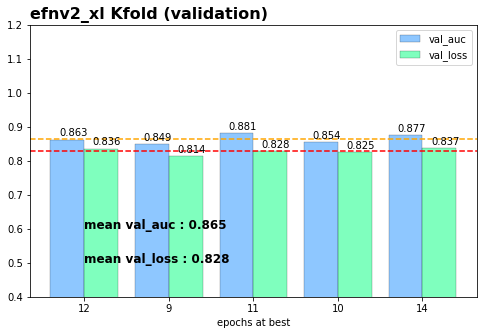

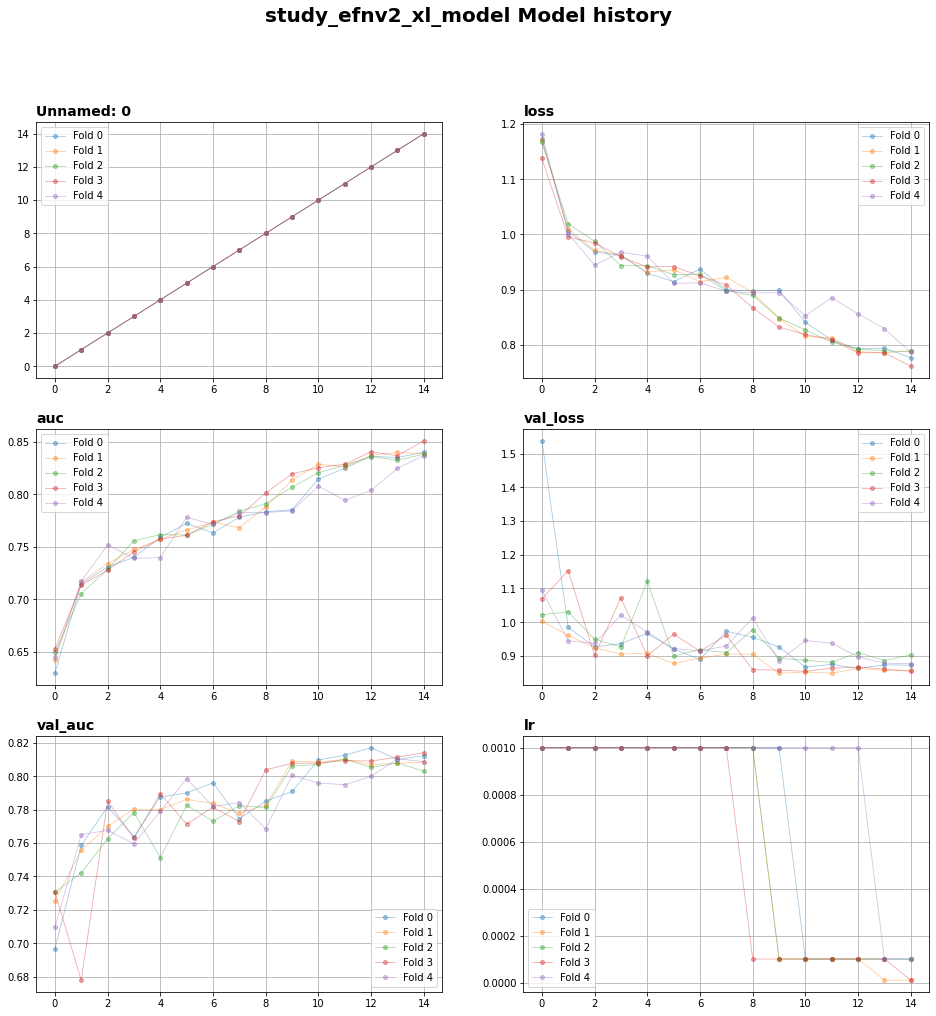

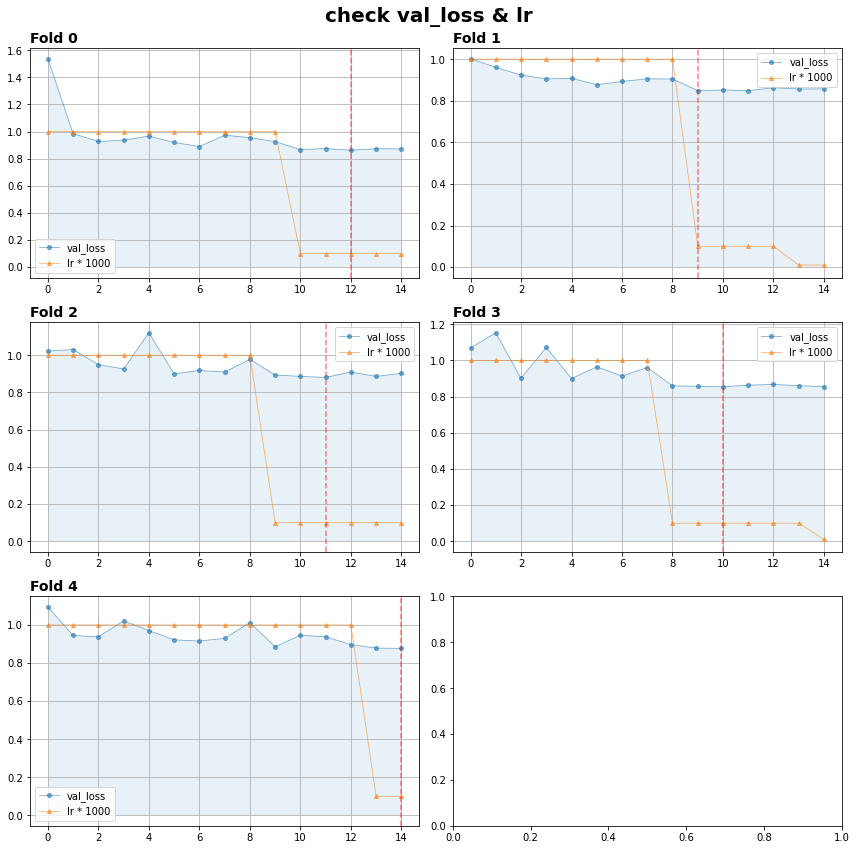

In [7]:
efnv2xl = analyze(model_lst[2])
model_history[model_lst[2]] = efnv2xl

# model_history

|model|cv auc|LB|
|-|-|-|
|efnb7 cv | 0.787 | 0.438|
|efnv2 xl | 0.865 | 0.443|   




In [53]:
model_history.keys()

dict_keys(['effnb7', 'efnv2', 'efnv2_xl'])

In [57]:
len(model_history['effnb7'])

5